In [851]:
#This is a class for reading edf files in python
import os
import struct
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline  

In [852]:
#Need to add other channel attributes such as analog,digital max and min, 
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None,byteLength=None):
        self.edfFile = edfFile
        self.label = label
        self.sampleRate = sampleRate
        #self.indexStart = indexStart
        self.transducer = transducer
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = channelIndex
        self.byteLength = byteLength
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            return self.label + " - "+str(self.channelIndex)
        
    def returnData(self,start,duration,channelNumber):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time of record desired in seconds
        ##########This might be easier to do within original edf class
        '''
        toReturn = []
        seekLocation = int(self.channelIndex + start*2)
        numberOfBytes = int(self.sampleRate) * duration 
        self.edfFile.edfRawData.seek(seekLocation)
        for i in xrange(numberOfBytes):
            value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
            value -= channelNumber*256
            toReturn.append(value)
            #toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
            
        return toReturn
        
    def channelIndex(self):
        return self.channelIndex
    
    def returnLabel(self):
        return self.label
    
    def notes(self):
        return self.notes
    
    

class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nheader Bytes: " 
                + str(self.headerBytes) + "\nNum Records :" 
                + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) + "\nFile Size: "+str(self.fileSize))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
        
    def printId(self):
        print"File Id: "+str(self.fileId)
   
    def fileParams(self):
        print("File Size: "+str(self.fileSize))
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(100000)
        #self.edfRawData.seek(0)
        #print(self.edfRawData.read(10))
        #print("Some Bits: "+str(bits))
        return bits
        
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel.
        '''
        #Header Fields
        self.version = self.edfRawData.read(8)
        self.patientId = self.edfRawData.read(80)
        self.recordId = self.edfRawData.read(80)
        self.startDate = self.edfRawData.read(8)
        self.startTime = self.edfRawData.read(8)
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = self.edfRawData.read(44)
        self.nRecords = int(self.edfRawData.read(8))
        self.duration = self.edfRawData.read(8)
        self.nSignals = int(self.edfRawData.read(4))
        
        #Create channel object for each channel
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.edfRawData.read(self.nSignals*16).split()
        self.channels['transducer'] = self.edfRawData.read(self.nSignals*80).split()
        self.channels['dimensions'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['physMin'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['physMax'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['digMin'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['digMax'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['preFilter'] = self.edfRawData.read(self.nSignals*80).split()
        self.channels['sampleRate'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['reservedNotes'] = self.edfRawData.read(self.nSignals*32).split()
        
        self.channelObjects = []
        channelDataStart = self.headerBytes
        
        #This loop creates and add channel objects to self.channelObjects
        for i in xrange(int(self.nSignals)):
            
            channelValues ={'filepath':self.filePath}
            byteLength = int(self.channels['sampleRate'][i])*self.nRecords*i*2
            channelIndex = channelDataStart + byteLength
            
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            self.channelObjects.append(
                channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelIndex,byteLength))
            
    def returnData(self,start,duration):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.returnLabel(),x.returnData(start,duration,j)])
            j+=1
        return sampleData
        
        
    
        #self.edfRawData.seek(240000)
        
        #print("100 Bytes of EEG \n"+str(self.edfRawData.read(100)))
    def parseTest(self):
        print "version: " + str(self.version)
        print "header Bytes: " + str(self.headerBytes)
        print "Num Records :" + str(self.nRecords)
        print "Num Signals :" + str(self.nSignals)
        '''
        print "Labels: "+str(self.labels[3])
        print "Num Labels: "+str(len(self.labels))
        print "Transducer: "+str(self.transducer)
        print "Dimensions: "+str(self.dimensions)
        print "physMin: "+str(self.physMin)
        print "physMax: "+str(self.physMax)
        print "digMin: "+str(self.digMin)
        print "digMax: "+str(self.digMax)
        print "Filter: "+str(self.preFilter)
        print "Samples in Record: "+str(self.sampleRate)
        print "Reserved Notes: "+str(self.reservedNotes)
        print ""
        print "Channel Byte Length: "+str(self.channelLength)
        print "Channel Indices: "+str(self.channelStarts)
        '''
        self.sampleData = []
        j=0
        for x in self.channelObjects:
            self.sampleData.append([x.returnLabel(),x.returnData(300,10,j)])
            j+=1
        
        
            
        print ("----------------------------------------------\nChannel Dict: "+str(self.channels['labels'])+
               "\n----------------------------------------------")
        
        for x in self.channelObjects:
            print x
        #self.sampleDataList = []    
        #for i in xrange(1000):
        #    self.sampleDataList.append(struct.unpack('h',self.edfRawData.read(2))[0])
        
        #print "Raw Data 1"+str(float(dataSample))
        
        
        
        #DFARF#!!!!!!!!!!!!!!!!!
        
        # Add edfFile function to return data for all channels for specified time period, also add functions 
        # for scrolling forward and backwards.
        
        #
        
        
        

In [853]:
edfFile1 = edfData(1)
edfFile1.loadFile("chb01_01.edf")
edfFile1.parseEdf()

In [860]:
plotData = edfFile1.returnData(310,10)
print "Buffer Bytes: "+str(sys.getsizeof(plotData))

Buffer Bytes: 272


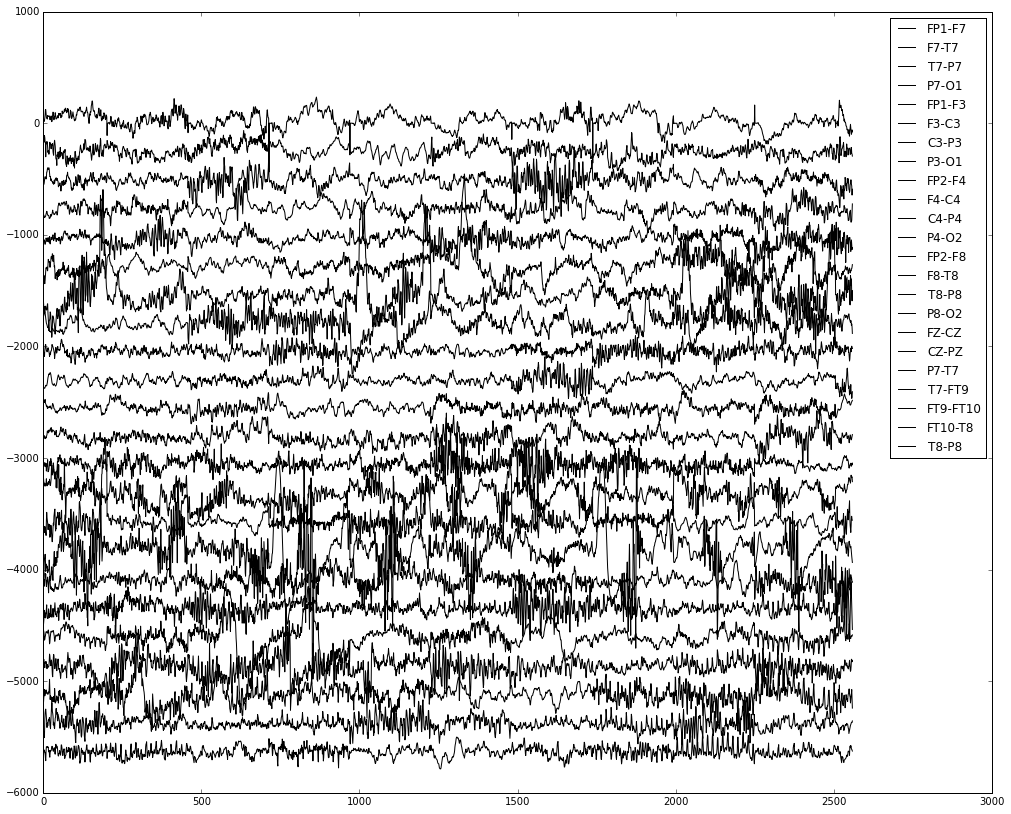

In [861]:
plt.figure(figsize=(17,14))
for x in plotData:
    plt.plot(x[1],color='black',label=x[0])
plt.legend()

In [822]:

#edfFile1.fileParams()

#b = x.read(1)
#firstfivebits = b >> 3

#

edfFile1.parseEdf()
edfFile1.parseTest()
print(edfFile1)

version: 0       
header Bytes: 6144
Num Records :3600
Num Signals :23
Seek Location: 6744
Number of Bytes: 2560
Sample Rate: 256
EDF Raw: ����������
Seek Location: 1849944
Number of Bytes: 2560
Sample Rate: 256
EDF Raw:  ����6  
Seek Location: 3693144
Number of Bytes: 2560
Sample Rate: 256
EDF Raw: ����������
Seek Location: 5536344
Number of Bytes: 2560
Sample Rate: 256
EDF Raw: ����������
Seek Location: 7379544
Number of Bytes: 2560
Sample Rate: 256
EDF Raw: ��
 ������
Seek Location: 9222744
Number of Bytes: 2560
Sample Rate: 256
EDF Raw: ����������
Seek Location: 11065944
Number of Bytes: 2560
Sample Rate: 256
EDF Raw: ��M�W
Seek Location: 12909144
Number of Bytes: 2560
Sample Rate: 256
EDF Raw: + # # !  
Seek Location: 14752344
Number of Bytes: 2560
Sample Rate: 256
EDF Raw:    6  
Seek Location: 16595544
Number of Bytes: 2560
Sample Rate: 256
EDF Raw: ����������
Seek Location: 18438744
Number of Bytes: 2560
Sample Rate: 256
EDF Raw: b I J E H 
Seek Location: 20281944
N